In [54]:
import os
import numpy as np
import numpy.ma as ma
from astropy.io import ascii
from astropy.table import Table,Column,JSViewer
from astropy import units as u
from astropy.visualization import quantity_support
from astropy.constants import L_sun, M_sun, R_sun,sigma_sb
from math import pi
quantity_support()
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
#import pandas as pd


In [116]:
def getcolor(si):
    if si == "N/A": return 'black'
    if si.startswith("O") or si.startswith("sdO"): return 'gray'
    if si.startswith("B") or si.startswith("sdB"): return 'blue'
    if si.startswith("A") or si.startswith("sdA"): return 'cyan'
    if si.startswith("F") or si.startswith("sdF"): return 'gold'
    if si.startswith("G") or si.startswith("sdG"): return 'green'
    if si.startswith("K") or si.startswith("sdK"): return 'darkorange'
    if si.startswith("M") or si.startswith("sdM"): return 'red'
    if si.startswith("DA"): return'purple'
    return 'black'


def getlumclassmarker(si):
    if si.endswith("I"): return "P"
    if si.endswith("II"): return "v"
    if si.endswith("III"): return "^"
    if si.endswith("IV"): return "+"
    if si.endswith("V") or si[-1].isdigit(): return "o"
    if si.endswith("VI") or si.startswith("sd"): return "s"
    if si.endswith("VII") or si.startswith("DA"): return "*"
    return "x"

def getlumclass(si):
    if si.endswith("I"): return "I"
    if si.endswith("III"): return "III"
    if si.endswith("II"): return "II"
    if si.endswith("IV"): return "IV"
    if si.endswith("V") or si[-1].isdigit(): return "V"
    if si.endswith("VI") or si.startswith("sd"): return "VI"
    if si.endswith("VII") or si.startswith("DA"): return "VII"
    return "x"

def has_spcolor(si):
    c = getlumclass(si)
    return c == "V" or c == "I" or c == "III"

lu = dict()
lu['P'] = 'I - supergiants'  
lu['v'] = 'II - bright giants'
lu['^'] = 'III - giants'
lu['+'] = 'IV - subgiants'
lu['o'] = 'V - main sequence'
lu['s'] = 'VI - subdwarfs'
lu['*'] = 'VII - white dwarfs'
lu['x'] = 'other'

In [64]:
dir = 'fits_ugriz'
figname = "HRdiagramugriz.pdf"
#dir = 'fits_UBVRIJHK'
#figname = "HRdiagramUBVRIJHK.pdf"
input_files = []
colvalues=[]
colnames = []
for file in os.listdir(dir):
    if file.endswith(".txt"):
        fname = os.path.join(dir, file)
        input_files.append(fname)
# get the headers
f = open(input_files[0],'r')
z= f.readline().split()
colnames.extend(z)
z= f.readline().split()
colnames.extend(z)
# get junk line
f.readline()
colvalues.extend(f.readline().split())
colvalues.extend(f.readline().split())
f.close()
colunits = ['' for x in colvalues]
colunits[6] = 'mag'
# another way
x = colvalues[8]*u.solRad
colvalues[8] = x.decompose().scale
#colvalues[8] *= R_sun
#colvalues[8] = colvalues[8].value
print(type(colvalues[8]))
colunits[8] = 'm'
colunits[9]  = 'K'
colunits[11] = 'degree'
coldtypes=[np.dtype(np.object),np.dtype(np.int32),np.dtype(np.int32),np.dtype(np.int32),np.dtype(np.object),np.dtype(np.float),np.dtype(np.float),np.dtype(np.float),np.dtype(np.float),np.dtype(np.float),np.dtype(np.float),np.dtype(np.float)]
coldesc = ['name', 'number of fit points', 'number of fits', 'fit number','best fit model', 'goodness of fit', 'extinction', 'scale factor', 'stellar radius', 'stellar temperature', 'scattering', 'viewing angle']
for i in range(len(colnames)):
  print('%s %s %s %s %s'% (colnames[i],colvalues[i],colunits[i],coldtypes[i],coldesc[i]))



<class 'float'>
source_name G_162-66  object name
n_data 8  int32 number of fit points
n_fits 1  int32 number of fits
fit_id 1  int32 fit number
model_name PbIKVB9Y_01  object best fit model
chi2 1400064.599  float64 goodness of fit
av 3.237 mag float64 extinction
scale -1.447  float64 scale factor
star.radius 70196130.0 m float64 stellar radius
star.temperature 1.399e+04 K float64 stellar temperature
scattering 1.000e+00  float64 scattering
inclination 4.500e+01 degree float64 viewing angle


In [102]:
t = Table(names=colnames,dtype=coldtypes)
#t.add_row(colvalues)
#for i in range(len(colnames)):
#   c = Column([colvalues[i]],unit=colunits[i],description=coldesc[i])
#   t[colnames[i]] = c
#   print(colnames[i])
#print(t['chi2'])
for i in range(len(colnames)):
    t[colnames[i]].unit = colunits[i]
for i in range(0,len(input_files)):
    f = open(input_files[i],'r')
    f.readline()
    f.readline()
    f.readline()
    colvalues=[]
    colvalues.extend(f.readline().split())
    if(colvalues[-1] == '0'): continue
    #print("%s %s"%(input_files[i],colvalues[-1]))
    colvalues.extend(f.readline().split())  
    #print("%s %d"%(input_files[i],len(colvalues)))
    x = colvalues[8]*u.solRad
    colvalues[8] = x.decompose().scale
    #colvalues[8] = float(colvalues[8])*R_sun
    #print(colvalues[8],x)
    #colvalues[8] = colvalues[8].value
    t.add_row(colvalues)
    f.close()
t.add_index('source_name')
#t.loc['BD+2_3375']['star.radius']
t.show_in_notebook(display_length=20)

idx,source_name,n_data,n_fits,fit_id,model_name,chi2,av,scale,star.radius,star.temperature,scattering,inclination
,,,,,,,mag,,m,K,,deg
0,G_162-66,8,1,1,PbIKVB9Y_01,1400064.599,3.237,-1.447,70196130.0,13990.0,1.0,45.0
1,GD_246,8,1,1,hJvFwktd_01,1335344.554,2.427,-1.12,69639570.0,23010.0,1.0,45.0
2,PG0918+029D,8,3,1,hK7Xrowi_01,172.163,0.356,0.131,5728393800.0,4806.0,1.0,45.0
3,PG1323-086D,8,1,1,XAsZi6yF_01,446.35,0.726,-0.57,671837490.0,6573.0,1.0,45.0
4,PG2336+004B,8,1,1,t1Ca8En3_01,4162.547,0.319,-0.323,864755100.0000001,6520.0,1.0,45.0
5,Ru_149B,8,1,1,sTefUKp6_01,119.74,0.411,-0.276,1097118900.0,5994.0,1.0,45.0
6,Ru_149F,8,4,1,jitXkVWB_01,101.857,0.063,0.568,9482391000.0,4539.0,1.0,45.0
7,SA_100_241,8,1,1,1gBBalDM_01,107.475,0.312,-0.316,1476971100.0000002,8517.0,1.0,45.0
8,SA_101_207,8,2,1,GfAeFN9b_01,976.278,0.414,-0.295,969110100.0,6498.0,1.0,45.0


In [103]:
#print(t['star.radius'])
t['star.luminosity'] = 4.0*pi*sigma_sb*(t['star.radius']**2)*(t['star.temperature']**4)
t['star.Lsun'] = t['star.luminosity']/L_sun
t['star.luminosity'].unit = 'W'
t['star.luminosity'].format='4.3E'
t['star.radius'].format='4.3E'
t['star.Lsun'].unit='Lsun'
t['star.Lsun'].format='5.3f'
t['star.Rsun'] = t['star.radius']/R_sun # yes I know...
t['star.Rsun'].unit='Rsun'
t['star.Rsun'].format='5.3f'

#print(L_sun)
#print(1*u.solRad.decompose().scale)
#print((4*pi*sigma_sb*(R_sun**2)*(5830*u.K)**4)/L_sun)

t['star.SpType'] = Column(name='star.SpType',length=len(t),dtype=np.object)
standards = Table.read("sdss_standards.votab")
sptype = []
standards.add_index('StarName')
for sj in t['source_name']:
    spacename = sj.replace('_',' ')
    z = standards.loc[spacename]['SpType']
    t.loc[sj]['star.SpType']= z.replace(":","")
#    print(standards.loc[spacename]['SpType'],standards.loc[spacename]['MK_Spectral_type'])
t.show_in_notebook(display_length=2)

idx,source_name,n_data,n_fits,fit_id,model_name,chi2,av,scale,star.radius,star.temperature,scattering,inclination,star.luminosity,star.Lsun,star.Rsun,star.SpType
,,,,,,,mag,,m,K,,deg,W,solLum,solRad,
0,G_162-66,8,1,1,PbIKVB9Y_01,1400064.599,3.237,-1.447,7.020E+07,13990.0,1.0,45.0,1.345E+26,0.351,0.101,DA2
1,GD_246,8,1,1,hJvFwktd_01,1335344.554,2.427,-1.12,6.964E+07,23010.0,1.0,45.0,9.687E+26,2.531,0.100,DA1
2,PG0918+029D,8,3,1,hK7Xrowi_01,172.163,0.356,0.131,5.728E+09,4806.0,1.0,45.0,1.247E+28,32.587,8.234,N/A
3,PG1323-086D,8,1,1,XAsZi6yF_01,446.35,0.726,-0.57,6.718E+08,6573.0,1.0,45.0,6.003E+26,1.568,0.966,N/A
4,PG2336+004B,8,1,1,t1Ca8En3_01,4162.547,0.319,-0.323,8.648E+08,6520.0,1.0,45.0,9.629E+26,2.516,1.243,N/A
5,Ru_149B,8,1,1,sTefUKp6_01,119.74,0.411,-0.276,1.097E+09,5994.0,1.0,45.0,1.107E+27,2.892,1.577,N/A
6,Ru_149F,8,4,1,jitXkVWB_01,101.857,0.063,0.568,9.482E+09,4539.0,1.0,45.0,2.720E+28,71.044,13.630,N/A
7,SA_100_241,8,1,1,1gBBalDM_01,107.475,0.312,-0.316,1.477E+09,8517.0,1.0,45.0,8.179E+27,21.367,2.123,A3
8,SA_101_207,8,2,1,GfAeFN9b_01,976.278,0.414,-0.295,9.691E+08,6498.0,1.0,45.0,1.193E+27,3.117,1.393,F8


In [62]:
t[:15]
#tcolors = Table.read("sptype_colors.tab",format="ipac")
#tcolors[:10]
#spcolors = dict(zip(tcolors['sptype'],tcolors['B_V']))
#spcolors["A2V"]
#print(t['star.SpType'])
#for i in range(len(t)):
#    print("%s "%t['star.SpType'][i])

source_name,n_data,n_fits,fit_id,model_name,chi2,av,scale,star.radius,star.temperature,scattering,inclination
,,,,,,mag,,m,K,,deg
object,int32,int32,int32,object,float64,float64,float64,float64,float64,float64,float64
G_162-66,8,1,1,PbIKVB9Y_01,1400064.599,3.237,-1.447,70196130.0,13990.0,1.0,45.0
GD_246,8,1,1,hJvFwktd_01,1335344.554,2.427,-1.12,69639570.0,23010.0,1.0,45.0
PG0918+029D,8,3,1,hK7Xrowi_01,172.163,0.356,0.131,5728393800.0,4806.0,1.0,45.0
PG1323-086D,8,1,1,XAsZi6yF_01,446.35,0.726,-0.57,671837490.0,6573.0,1.0,45.0


In [115]:
classes = []
colors = []
for j in t['star.SpType']:
    #print(j)
    colors.append(getcolor(j))
    classes.append(getlumclassmarker(j))

In [111]:
#t.write('ugriz_parameters.tab',format='votable',overwrite=True)
t.write('UBVRIJHK_parameters.tab',format='votable',overwrite=True)

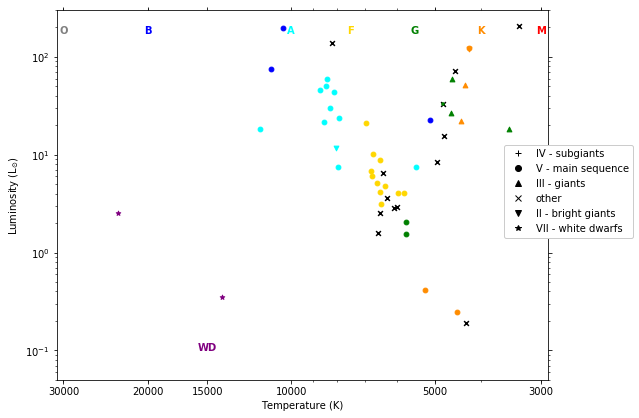

In [123]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [8.8,6.8]
import matplotlib.ticker
for x,y,c,m in zip(t['star.temperature'],t['star.Lsun'],colors,classes):
#plt.scatter((t['star.temperature']),(t['star.Lsun']),c=colors,s=10,marker=classes)
    plt.scatter(x,y,c=c,s=23,marker=m)
plt.xlim(2900,31000)
plt.ylim(0.05,300)
plt.xlabel("Temperature (K)")
plt.ylabel("Luminosity (L$_{\odot}$)")
ax = plt.gca()
ax.invert_xaxis()
plt.text(30000,175,"O",horizontalalignment='center',color=getcolor("O"),weight='bold')
plt.text(20000,175,"B",horizontalalignment='center',color=getcolor("B"),weight='bold')
plt.text(10000,175,"A",horizontalalignment='center',color=getcolor("A"),weight='bold')
plt.text(7500,175,"F",horizontalalignment='center',color=getcolor("F"),weight='bold')#,backgroundcolor='gray')
plt.text(5500,175,"G",horizontalalignment='center',color=getcolor("G"),weight='bold')
plt.text(4000,175,"K",horizontalalignment='center',color=getcolor("K"),weight='bold')
plt.text(3000,175,"M",horizontalalignment='center',color=getcolor("M"),weight='bold')
plt.text(15000,0.1,"WD",horizontalalignment='center',color=getcolor("DA"),weight='bold')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xticks([3000,5000,10000,15000,20000,30000])
ax.tick_params(bottom=True,top=True,left=True,right=True)
ax.tick_params(top=True, which="minor",axis="x")
ax.tick_params(right=True, which="minor",axis="y")

ax.get_xaxis().set_major_formatter(ScalarFormatter())
#ax.get_xaxis().set_minor_formatter(ScalarFormatter())
cu = list(set(classes))
#print(cu)
#plt.title('Fitted vs. Observed Spectral Types for UBVRIJHK of SDSS Standard Stars')

patches = [plt.plot([],[],marker=z,ls="",color='black',label=lu[z])[0] for z in cu]
plt.legend(handles=patches,loc='best',numpoints=1,ncol=1, bbox_to_anchor=(.9,0.65),framealpha=1)
plt.savefig("HRdiagramUBVRIJHK.pdf")
